# Data loading

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ztest


In [ ]:
!gdown "1iAHwMI4QMlz9toYbPjEvxIqBU89N2msI"

df=pd.read_csv("Twitter A_B testing.csv")
df.tail()

Downloading...
From: https://drive.google.com/uc?id=1iAHwMI4QMlz9toYbPjEvxIqBU89N2msI
To: /content/Twitter A_B testing.csv
100% 436k/436k [00:00<00:00, 73.9MB/s]


,treatment,company_size,campaign_spend,campaign_budget
15469,True,small,32.0107,47.5802
15470,True,large,55.2560,44.3909
15471,True,small,94.2496,89.0695
15472,True,medium,2401.8596,3530.2232
15473,True,small,14.6699,14.5895


In [ ]:
df.isna().sum()       #no nulls

,0
treatment,0
company_size,0
campaign_spend,0
campaign_budget,0


Basic data cleaning and analysis

In [ ]:
df[df.duplicated()]       #no duplicates either

,treatment,company_size,campaign_spend,campaign_budget


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   treatment        15474 non-null  bool   
 1   company_size     15474 non-null  object 
 2   campaign_spend   15474 non-null  float64
 3   campaign_budget  15474 non-null  float64
dtypes: bool(1), float64(2), object(1)
memory usage: 377.9+ KB


In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
treatment,15474,2,True,7741,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_size,15474,3,small,8901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign_spend,15474.0,NaN,NaN,NaN,4903.03678,65166.919608,0.3595,15.178125,50.09005,236.546775,5289216.884
campaign_budget,15474.0,NaN,NaN,NaN,5772.614404,99033.807673,0.0919,12.7929,48.81625,252.315475,10242888.21


In [ ]:
col=df.columns
print(col)

Index(['treatment', 'company_size', 'campaign_spend', 'campaign_budget'], dtype='object')


# Tasks:

### (1) How many campaigns have overspent of greater than 1% of their budget in the control group? In the treatment group?

In [ ]:
#creating a new column overspent_percent
df["overspent_percent"]=((df["campaign_spend"]-df["campaign_budget"])/df["campaign_budget"])*100
df.head()

,treatment,company_size,campaign_spend,campaign_budget,overspent_percent
0,False,small,10.4477,3.9035,167.649545
1,False,medium,3.7776,1.9872,90.096618
2,False,medium,46.1880,55.4523,-16.706791
3,False,small,6.6271,6.5136,1.742508
4,False,small,92.3405,83.1018,11.117328


In [ ]:
# Filter for overspent > 1%
overspent_df = df[df['overspent_percent'] > 1]

# Count per group
overspent_counts = overspent_df['treatment'].value_counts()
overspent_counts

,count
treatment,
False,5716
True,5180


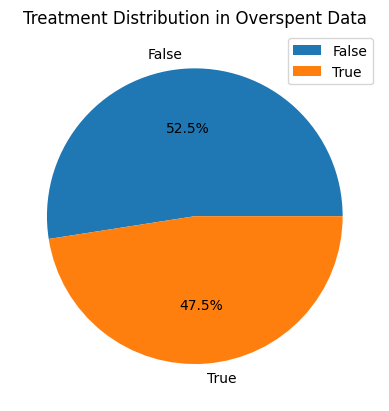

In [ ]:
plt.pie(overspent_counts, labels=overspent_counts.index, autopct='%1.1f%%')
plt.title('Treatment Distribution in Overspent Data')
plt.legend()
plt.show()

### (2) Was the new product effective at reducing overspend, and was it more or less effective depending on the company size? Put together an analysis describing how the treatment affected overspend.

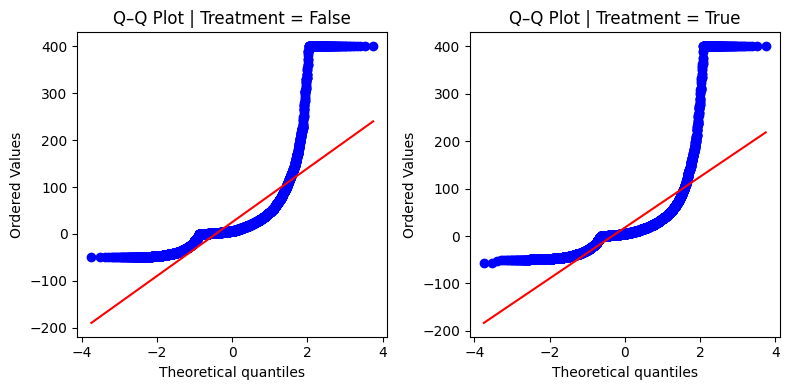

In [ ]:
treatments = df["treatment"].unique()

plt.figure(figsize=(8, 4))

for i, treatment in enumerate(treatments, 1):
    plt.subplot(1, 2, i)
    data = df[df["treatment"] == treatment]["overspent_percent"]
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"Q–Q Plot | Treatment = {treatment}")

plt.tight_layout()
plt.show()


In [ ]:
treatments_iter = df["treatment"].unique()

for treatment in treatments_iter:
  stat, p_value = stats.shapiro(df[df["treatment"] == treatment]["overspent_percent"])
  print(f"treatment: {treatment}, p_value: {p_value:.2f}", "normally distributed" if p_value > 0.05 else "not normally distributed")
  print()
  print(50 * "__")


treatment: False, p_value: 0.00 not normally distributed

____________________________________________________________________________________________________
treatment: True, p_value: 0.00 not normally distributed

____________________________________________________________________________________________________


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7733.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7741.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# using Mann–Whitney U test to check if overspent_percent is greater in control group than treatment
# H0: Median (control) ≤ Median (treatment)
# H1: Median (control) > Median (treatment)

group_false = df[df["treatment"] == False]["overspent_percent"]
group_true = df[df["treatment"] == True]["overspent_percent"]

stat, p_value = stats.mannwhitneyu(group_false, group_true, alternative='greater')

print(f"p_value: {p_value:.4f}","|", " significant difference" if p_value < 0.05 else " no significant difference")


p_value: 0.0000 |  significant difference


In [ ]:
treatments_iter=df["treatment"].unique()
company_iter=df["company_size"].unique()


for company_size in company_iter:
  for treatment in treatments_iter:
    stat, p_value=stats.shapiro(df[(df["company_size"]==company_size) & (df["treatment"]==treatment)]["overspent_percent"])
    print(f"company size: {company_size},treatment: {treatment}, p_value:{p_value:.2f}", "normally distributed" if p_value>0.05 else "not normally distributed")
    print()
    print(50*"__")

company size: small,treatment: False, p_value:0.00 not normally distributed

____________________________________________________________________________________________________
company size: small,treatment: True, p_value:0.00 not normally distributed

____________________________________________________________________________________________________
company size: medium,treatment: False, p_value:0.00 not normally distributed

____________________________________________________________________________________________________
company size: medium,treatment: True, p_value:0.00 not normally distributed

____________________________________________________________________________________________________
company size: large,treatment: False, p_value:0.00 not normally distributed

____________________________________________________________________________________________________
company size: large,treatment: True, p_value:0.00 not normally distributed

__________________________________

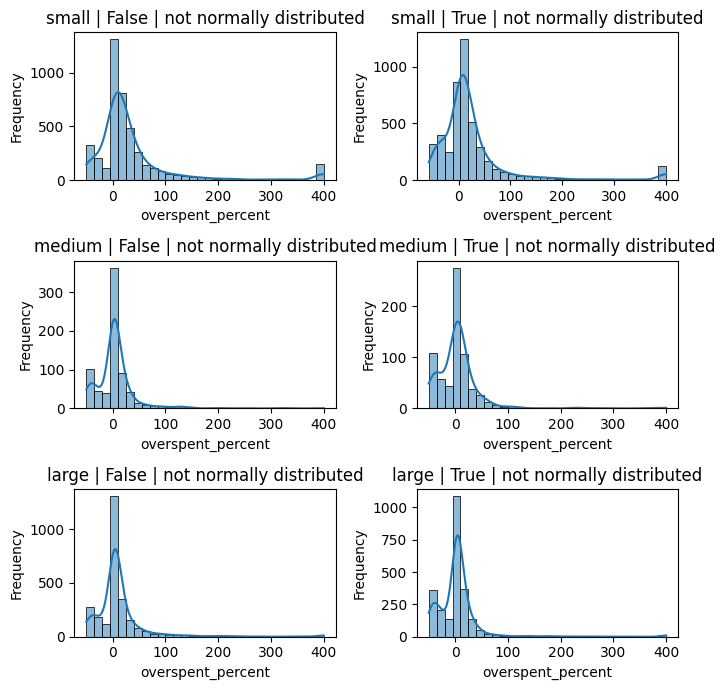

In [ ]:
n_rows = len(company_iter)
n_cols = len(treatments_iter)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7, 7))


for i, company_size in enumerate(company_iter):
    for j, treatment in enumerate(treatments_iter):
        subset = df[(df["company_size"] == company_size) & (df["treatment"] == treatment)]["overspent_percent"]

        # Shapiro wilk's test to check if normal
        stat, p_value = stats.shapiro(subset)
        normality = "normally distributed" if p_value > 0.05 else "not normally distributed"

        # Plot histogram
        ax = axes[i, j]
        sns.histplot(subset, kde=True, bins=30, ax=ax)
        ax.set_title(f"{company_size} | {treatment} | {normality}")
        ax.set_xlabel("overspent_percent")
        ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
#trying log tranformation to see if that returns a nromal distribution

df["log_overspent"] = np.log(1 + df["overspent_percent"])
treatments_iter = df["treatment"].unique()
company_iter = df["company_size"].unique()

for company_size in company_iter:
  for treatment in treatments_iter:
    stat, p_value = stats.shapiro(df[(df["company_size"] == company_size) & (df["treatment"] == treatment)]["log_overspent"])
    print(f"company size: {company_size},treatment: {treatment}, p_value:{p_value}", "normally distributed" if p_value > 0.05 else "not normally distributed")
    print(50*"__")



company size: small,treatment: False, p_value:nan not normally distributed
____________________________________________________________________________________________________
company size: small,treatment: True, p_value:nan not normally distributed
____________________________________________________________________________________________________
company size: medium,treatment: False, p_value:nan not normally distributed
____________________________________________________________________________________________________
company size: medium,treatment: True, p_value:nan not normally distributed
____________________________________________________________________________________________________
company size: large,treatment: False, p_value:nan not normally distributed
____________________________________________________________________________________________________
company size: large,treatment: True, p_value:nan not normally distributed
______________________________________________

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# using Mann–Whitney U test
# H0: median (treatment) ≥ median (control)
# H1: median (treatment) < median (control)

for company_size in df["company_size"].unique():
  group_false = df[(df["company_size"] == company_size) & (df["treatment"] == False)]["overspent_percent"]
  group_true = df[(df["company_size"] == company_size) & (df["treatment"] == True)]["overspent_percent"]
  stat, p_value = stats.mannwhitneyu(group_false, group_true,alternative="greater")
  print(f"company size: {company_size}, p_value: {p_value:.4f}", " significant difference" if p_value < 0.05 else " no significant difference")
  print(50*"__")
  print()


company size: small, p_value: 0.0000  significant difference
____________________________________________________________________________________________________

company size: medium, p_value: 0.6352  no significant difference
____________________________________________________________________________________________________

company size: large, p_value: 0.0000  significant difference
____________________________________________________________________________________________________



In [ ]:
# using t-test just to see if the results change, which they dont here

for company_size in df["company_size"].unique():
  group_false = df[(df["company_size"] == company_size) & (df["treatment"] == False)]["overspent_percent"]
  group_true = df[(df["company_size"] == company_size) & (df["treatment"] == True)]["overspent_percent"]
  stat, p_value = stats.ttest_ind(group_false, group_true, equal_var=False,alternative="greater")

  print(f"company size: {company_size}, p_value: {p_value:.4f}", "→ significant difference" if p_value < 0.05 else "→ no significant difference")
  print(50*"__")
  print()


company size: small, p_value: 0.0000 → significant difference
____________________________________________________________________________________________________

company size: medium, p_value: 0.6006 → no significant difference
____________________________________________________________________________________________________

company size: large, p_value: 0.0000 → significant difference
____________________________________________________________________________________________________



### (3) A product manager on the team is concerned that certain advertisers in the treatment group are entering lower budgets because they are wary of the new product. Provide some evidence to support their suspicions, or show that any differences in budgets are likely due to random fluctuations.

In [ ]:
budget_comparison = pd.crosstab(df["treatment"], df["company_size"], values=df["campaign_budget"], aggfunc="mean")
budget_comparison


company_size,large,medium,small
treatment,,,
False,5933.969191,6342.855039,3538.655751
True,17561.826013,4612.670890,1585.479895


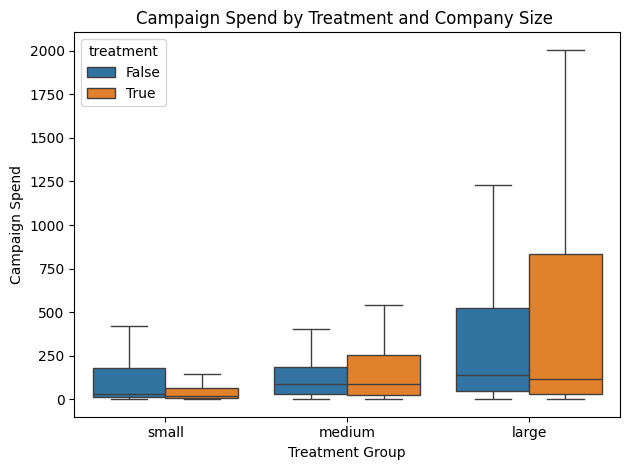

In [ ]:
sns.boxplot(data=df, x='company_size', y='campaign_spend', hue='treatment', showfliers=False)
plt.xlabel('Treatment Group')
plt.ylabel('Campaign Spend')
plt.title('Campaign Spend by Treatment and Company Size ')
plt.tight_layout()
plt.show()


In [ ]:
# Using Mann–Whitney U test to check if treatment group has lower campaign budgets
# H0: Median (control) ≤ Median (treatment)
# H1: Median (control) > Median (treatment)

group_false = df[df["treatment"] == False]["campaign_budget"]
group_true = df[df["treatment"] == True]["campaign_budget"]

stat, p_value = stats.mannwhitneyu(group_false, group_true, alternative='greater')  # control > treatment
print(f"p_value: {p_value:.4f}", "|", "significant drop in treatment group" if p_value < 0.05 else "no significant drop")


p_value: 0.0000 | significant drop in treatment group


In [ ]:
#checking if its normally distributed, however most financial data is not
treatments_iter=df["treatment"].unique()
company_iter=df["company_size"].unique()

for company_size in company_iter:
  for treatment in treatments_iter:
    stat, p_value=stats.shapiro(df[(df["company_size"]==company_size) & (df["treatment"]==treatment)]["campaign_budget"])
    print(f"company size: {company_size},treatment: {treatment}, p_value:{p_value:.2f}","|", "normally distributed" if p_value>0.05 else "not normally distributed")

company size: small,treatment: False, p_value:0.00 | not normally distributed
company size: small,treatment: True, p_value:0.00 | not normally distributed
company size: medium,treatment: False, p_value:0.00 | not normally distributed
company size: medium,treatment: True, p_value:0.00 | not normally distributed
company size: large,treatment: False, p_value:0.00 | not normally distributed
company size: large,treatment: True, p_value:0.00 | not normally distributed


In [ ]:
# using Mann–Whitney U test to test if treatment group has smaller campaign budgets
# H0: Median (control) ≤ Median (treatment)
# H1: Median (control) > Median (treatment)

for company_size in df["company_size"].unique():
  group_false = df[(df["company_size"] == company_size) & (df["treatment"] == False)]["campaign_budget"]
  group_true = df[(df["company_size"] == company_size) & (df["treatment"] == True)]["campaign_budget"]
  stat, p_value = stats.mannwhitneyu(group_false, group_true, alternative='greater')  # control > treatment
  print(f"company size: {company_size}, p_value: {p_value:.4f}","|", " significant drop in treatment group" if p_value < 0.05 else " no significant drop")
  print(50*"__")
  print()


company size: small, p_value: 0.0000 |  significant drop in treatment group
____________________________________________________________________________________________________

company size: medium, p_value: 0.8288 |  no significant drop
____________________________________________________________________________________________________

company size: large, p_value: 0.3599 |  no significant drop
____________________________________________________________________________________________________



In [ ]:
# using t-test just to see if the results change, which they dont here
# H0: Mean (control) ≤ Mean (treatment)
# H1: Mean (control) > Mean (treatment)

for company_size in df["company_size"].unique():
  group_false = df[(df["company_size"] == company_size) & (df["treatment"] == False)]["campaign_budget"]
  group_true = df[(df["company_size"] == company_size) & (df["treatment"] == True)]["campaign_budget"]
  stat, p_value = stats.ttest_ind(group_false, group_true, alternative='greater')  # control > treatment
  print(f"company size: {company_size}, p_value: {p_value:.3f}","|"," significant drop in treatment group" if p_value < 0.05 else " no significant drop")
  print(50*"__")
  print()


company size: small, p_value: 0.005 |  significant drop in treatment group
____________________________________________________________________________________________________

company size: medium, p_value: 0.126 |  no significant drop
____________________________________________________________________________________________________

company size: large, p_value: 0.994 |  no significant drop
____________________________________________________________________________________________________



### (4) What is the average overspend percentage for campaigns in both the control and treatment groups?

In [ ]:
breakdown=df.groupby(['treatment'])['overspent_percent'].mean()
breakdown

,overspent_percent
treatment,
False,25.32255
True,17.60635


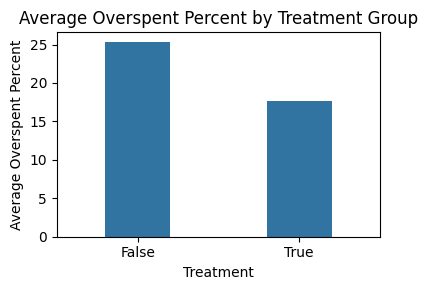

In [ ]:
breakdown = df.groupby('treatment', as_index=False)['overspent_percent'].mean()

# Plot using seaborn
plt.figure(figsize=(4, 3))
sns.barplot(data=breakdown, x='treatment', y='overspent_percent',width=0.4)
plt.title('Average Overspent Percent by Treatment Group')
plt.xlabel('Treatment')
plt.ylabel('Average Overspent Percent')
plt.tight_layout()
plt.show()

In [ ]:
breakdown=df.groupby(['company_size','treatment'])['overspent_percent'].mean().reset_index()
breakdown

,company_size,treatment,overspent_percent
0,large,False,12.293655
1,large,True,3.263995
2,medium,False,4.557030
3,medium,True,5.144382
4,small,False,37.064162
5,small,True,27.096085


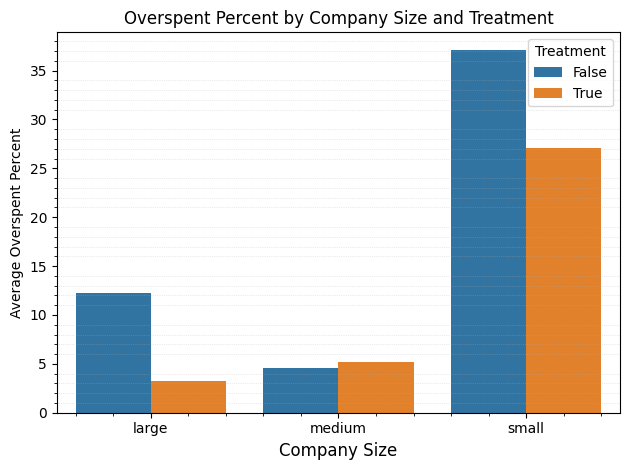

In [ ]:
sns.barplot(data=breakdown, x='company_size', y='overspent_percent', hue='treatment')
plt.xlabel('Company Size', fontsize=12)
plt.ylabel('Average Overspent Percent')
plt.title('Overspent Percent by Company Size and Treatment')
plt.legend(title='Treatment')
plt.minorticks_on()
plt.grid(visible=True, which='minor', axis='y', linestyle=':', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


### What demographic factors (company size) correlate with higher overspending rates in both groups?

In [ ]:

overspend_comparison = pd.crosstab(df["treatment"], df["company_size"], values=df["overspent_percent"], aggfunc="mean")
overspend_comparison.T


treatment,False,True
company_size,,
large,12.293655,3.263995
medium,4.557030,5.144382
small,37.064162,27.096085


### (10) Is the variance in campaign spend significantly different between the control and treatment groups?

In [ ]:
group_stats = df.groupby("treatment")["campaign_budget"].agg(["std", "var"])
group_stats


,std,var
treatment,,
False,47765.753797,2.281567e+09
True,131623.544113,1.732476e+10


In [ ]:
#using levene's test to check if variance or std
#H0: Same variance
#H1: Not same variance
control = df[df["treatment"] == False]["campaign_budget"]
treatment = df[df["treatment"] == True]["campaign_budget"]

stat, p_value = stats.levene(control, treatment, center='median')  # median is better as it is skewed data
print(f"Levene’s test p-value: {p_value:.2f}","|", "Significant difference in variance" if p_value < 0.05 else "No significant difference in variance")


Levene’s test p-value: 0.15 | No significant difference in variance


In [ ]:
# using Levene's test to check if variance in campaign_budget differs by treatment group within each company size
#H0: Same variance
#H1: Not same variance

for company_size in df["company_size"].unique():
    control = df[(df["company_size"] == company_size) & (df["treatment"] == False)]["campaign_budget"]
    treatment = df[(df["company_size"] == company_size) & (df["treatment"] == True)]["campaign_budget"]

    stat, p_value = stats.levene(control, treatment, center='median')  # median is better as it is skewed data
    print(f"Company Size: {company_size} | Levene’s p-value: {p_value:.2f}",
          "| Significant variance difference" if p_value < 0.05 else "| No significant variance difference")
    print(50 * "__")


Company Size: small | Levene’s p-value: 0.01 | Significant variance difference
____________________________________________________________________________________________________
Company Size: medium | Levene’s p-value: 0.25 | No significant variance difference
____________________________________________________________________________________________________
Company Size: large | Levene’s p-value: 0.01 | Significant variance difference
____________________________________________________________________________________________________
